In [40]:
# pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

In [41]:
df = pd.read_csv('insurance.csv')

In [42]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [43]:
df.duplicated().sum()

1

In [44]:
df.drop_duplicates(inplace=True)

In [45]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [46]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [47]:
df['sex'].replace(['female'], 0, inplace=True)
df['sex'].replace(['male'], 1, inplace=True)

df['smoker'].replace(['no'], 0, inplace=True)
df['smoker'].replace(['yes'], 1, inplace=True)

In [48]:
from sklearn.preprocessing import OneHotEncoder
variables = ['region']

encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

# splited regions into columns

In [49]:
X = df.drop("charges", axis=1)

# have only the target variable here (dependent variable)
y = df["charges"]

In [50]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=101)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=101)

In [51]:
training_variable_amount = len(X.columns)

model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(training_variable_amount,)),
        layers.Dense(24, activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.1)),
        layers.Dense(16, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(8, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(4, activation="relu"),
        layers.Dense(1)
    ]
)

model.compile(optimizer='adam', loss='mse')
model.summary()

model.fit(x=X_train, y=y_train, epochs=1000, validation_data=(X_val, y_val))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 9)                 36        
 Normalization)                                                  
                                                                 
 dense_16 (Dense)            (None, 24)                240       
                                                                 
 dense_17 (Dense)            (None, 16)                400       
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_18 (Dense)            (None, 8)                 136       
                                                                 
 dropout_5 (Dropout)         (None, 8)                 0         
                                                      

<Axes: >

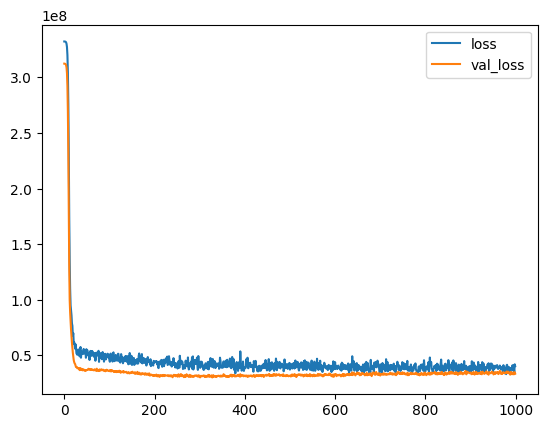

In [52]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [53]:
# compare the final model loss/evaluation values
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
28432852.0

Train data evaluation:
27636540.0


In [54]:
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

7/7 [==============================] - 0s 1ms/step


,Test True Y,Model Predictions
0,7443.64305,7764.953125
1,9249.49520,9312.096680
2,52590.82939,36184.390625
3,23045.56616,10240.823242
4,18972.49500,20225.841797
...,...,...
196,21259.37795,22571.490234
197,11552.90400,11328.628906
198,2117.33885,3222.782959
199,2457.21115,3866.832520


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

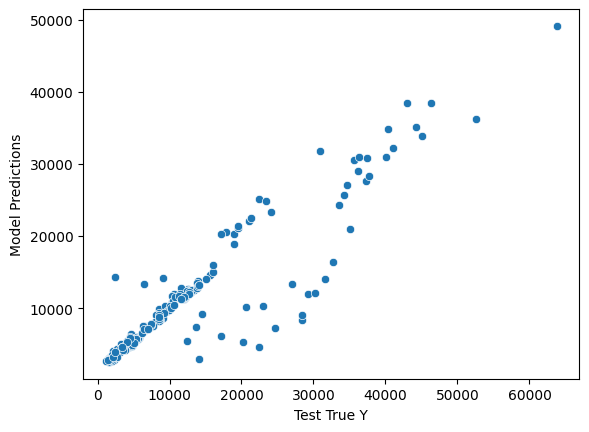

In [55]:
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

In [56]:
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
2767.39 $

MSE
28432842.39 $^2

RMSE:
5332.25 $

R-squared:
0.79

Explained variance score:
0.8


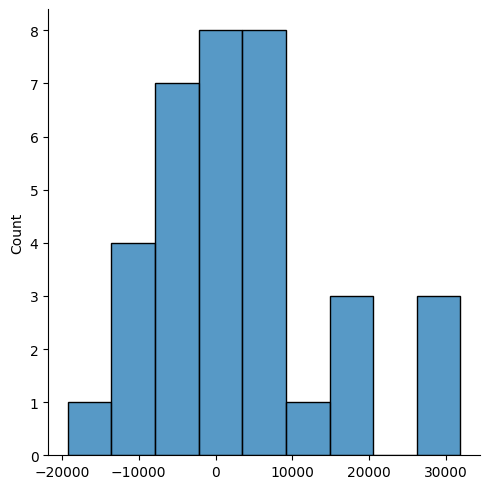

In [57]:
sns.displot((y_test - test_predictions))
plt.show()
plt.close()

In [63]:
tester_row = {
    'age': 19,
    'sex': 0,
    'bmi': 27,
    'children': 0,
    'smoker': 1,
    'region_northeast': 0,
    'region_northwest': 0,
    'region_southeast': 0,
    'region_southwest': 1
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

result = model.predict(tester_row)[0]

print()
print(f"Estimated charges:")
print(f"{round(float(result), 2)}")
print("----------------")

1/1 [==============================] - 0s 22ms/step

Estimated charges:
19735.32
----------------


C:\Users\Roman\AppData\Local\Temp\ipykernel_3756\595804597.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"{round(float(result), 2)}")


In [59]:
model.save('ANN_reg.keras')